# Deeplearning Workflow using PyTorch


1. Get data ready (create data tensors)
2. Build/Select a pretrained model
    2.1. Pick a loss function and optimizer
    b. Build a training loop
3. Fit the model to the data and make a prediction
4. Evaluate the model
5. Improve through experimentation
6. Save and reload our trained model


In [34]:
what_would_be_covered = {
    1: "data (prepare and load)",
    2: 'build model',
    3: 'fitting the model to data (training)',
    4: 'making predictions and evaluting a model (inference)',
    5: 'saving and loading a model',
    6: 'putting it all together'
}

In [35]:
import torch
from torch import nn # nn contains pytorch neural network related packages
import matplotlib.pyplot as plt

torch.__version__

'2.4.0.dev20240528'

## 1. Data (preparing and loading)
Data can be almost anything... in machine learning.

* Excel spreadsheet
* Images of any kind
* Audio/visual data (youtube/songs/podcasts)
* DNA
* Text

An eagle eye's view Machine learning majorly has two steps 
1. Get data into a numerical representation
2. Build a model to learn patterns in the numerical representation

Lets create some known linear regresion (y = f(x, b) + e) data, the simplest possible is y = x + bx

We will us the formula to make a straight line with known parameters


In [36]:
# create known parameters
weight = 0.3
bias = 0.8

# build a model to estimate this numbers
#create
start = 0 
end = 1
step = 0.02

# create a range from start to end this will create [0,0.02,....0.98] and unsequeeze to add another dimension 
# this will convert it into [[0,0.02...0.98]]
X = torch.arange(start, end, step).unsqueeze(dim=1)

y = weight * X + bias

# list first ten values
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.8000],
         [0.8060],
         [0.8120],
         [0.8180],
         [0.8240],
         [0.8300],
         [0.8360],
         [0.8420],
         [0.8480],
         [0.8540]]))

In [37]:
len(X), len(y)

(50, 50)

### Splitting the data into training and test sets
training set (60%) + validation set (20%) + test set (20%)

In [38]:
# Creating training split

train_split = int(0.6 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(30, 30, 20, 20)

### Visualizing the data 

We will be using matplotlib to better visualize the data.

In [39]:
def plot_predictions(
  train_data=X_train,
  train_labels=y_train,
  test_data= X_test,
  test_labels=y_test,
  prediction=None
  ):
  """
  Plots training data, test data and compares predictions.
  """

  plt.figure(figsize=(10,7))

  #plotting training data in blue
  plt.scatter(train_data, train_labels, s=6, c="b", label="Training data")

  plt.scatter(test_data, test_labels, s=6, c="g", label="Test data")  

  if prediction is not None: 
    plt.scatter(test_data, prediction, c="r", s=6, label="Predictions")

  plt.legend(prop={"size": 14})

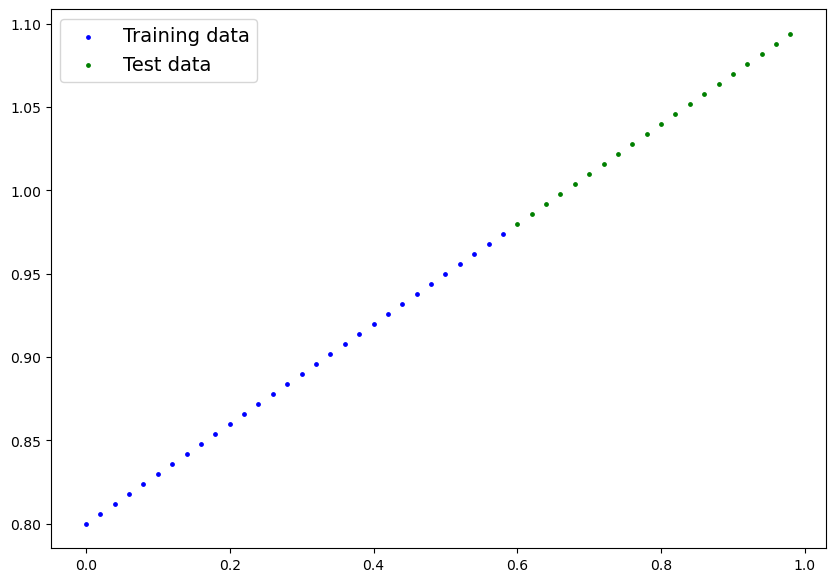

In [40]:
plot_predictions()

## Build Model

Create the linear regression model

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent the ideal values

It does with two main algorithms
1. Gradient Descent
2. Backpropagation

In [41]:
# create linear regression model class

class LinearRegressionModel(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias # this is the linear regression formula

### Pytorch model building essentials

* torch.nn contains building blocks for computation graph(neural network)
* torch.nn.Parameter , what parameters our model should try and learn
* torch.nn.Module, is the base class for all models, and when we inherit it, forward() should be defined
* torch.optim -> this are the optimizers that can be used eg gradiend descent
* def forward() -> All nn module should habe this function


In [42]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [43]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

As we are using requires_grad as true, pytorch keeps track of it everytime data is ran throwugh forward() method

In [44]:
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3308],
        [0.3376],
        [0.3443],
        [0.3510],
        [0.3578],
        [0.3645],
        [0.3712],
        [0.3780],
        [0.3847],
        [0.3914],
        [0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

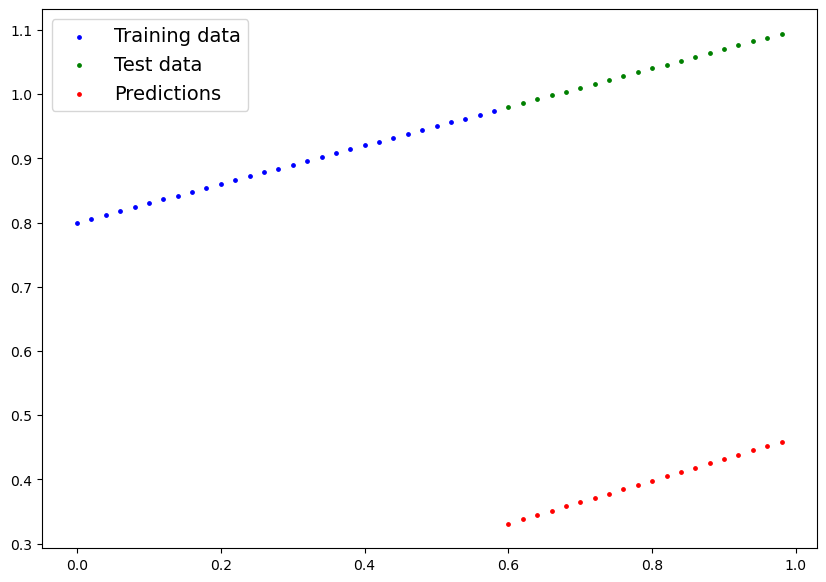

In [45]:
plot_predictions(prediction=y_preds)

## 3. Train model

Traini the model through unknown model to known model, or in other words from a poor representation of the data to better representation


This could be achived by using loss function , pytorch provides loss functions which we can use .

* **Loss Function**: is a function to measure how wrong the model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters to improve the loss function.

For puTorch  we need training and a testing loop

In [46]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [47]:
# Setup loss function
loss_fn = nn.L1Loss() # this is an mae calculates the difference and calculates average

# optimizer
# lr => learning rate, smaller the rate smaller the change in parameters
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)


### Building a training loop and a testing loop

**Training Loop**
0. Loop through the data
1. Forward pass/propagation  (this involves data flowing through `forward()` of the modal)
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respoect to the loss (**backpropagation**)
5. Optimizer step


In [48]:
epochs = 200


## Training loop
for epoch in range(epochs):
  #set the model to training mode
  model_0.train() # train mode in PyTorch sets all params that require gradients to track gradients

  #forward pass
  y_preds = model_0(X_train)
  # caluc loss
  loss = loss_fn(y_preds, y_train)
  #zero_grad
  optimizer.zero_grad()
  #backward propogation
  loss.backward()
  #optimizer
  #by default optimizer changes will accumulate through the loop
  #so we have to zero them
  optimizer.step()

  # testing
  model_0.eval() # turns off gradient tracking 
  with torch.inference_mode():

    test_pred = model_0(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | test loss: {test_loss}")
    print(model_0.state_dict())


Epoch: 0 | Loss: 0.6605504155158997 | test loss: 0.6299142241477966
OrderedDict({'weights': tensor([0.3396]), 'bias': tensor([0.1388])})
Epoch: 10 | Loss: 0.5521403551101685 | test loss: 0.5070041418075562
OrderedDict({'weights': tensor([0.3686]), 'bias': tensor([0.2388])})
Epoch: 20 | Loss: 0.4437303841114044 | test loss: 0.3840941786766052
OrderedDict({'weights': tensor([0.3976]), 'bias': tensor([0.3388])})
Epoch: 30 | Loss: 0.33532047271728516 | test loss: 0.2611842155456543
OrderedDict({'weights': tensor([0.4266]), 'bias': tensor([0.4388])})
Epoch: 40 | Loss: 0.2269105315208435 | test loss: 0.13827423751354218
OrderedDict({'weights': tensor([0.4556]), 'bias': tensor([0.5388])})
Epoch: 50 | Loss: 0.11850059777498245 | test loss: 0.021651331335306168
OrderedDict({'weights': tensor([0.4846]), 'bias': tensor([0.6388])})
Epoch: 60 | Loss: 0.03584592789411545 | test loss: 0.08025965094566345
OrderedDict({'weights': tensor([0.5035]), 'bias': tensor([0.7195])})
Epoch: 70 | Loss: 0.02962886

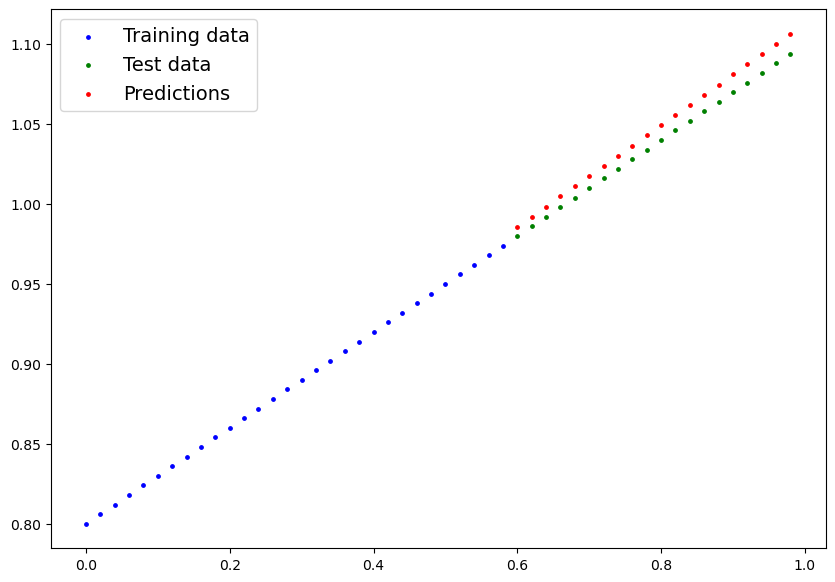

In [49]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_predictions(prediction=y_preds_new)

## Saving a model in PyTorch
There are three main methors for saving and loading models in PyTorch.

1. `toch.save()` This will use python pickle format
2. `torch.load()` - allows you to load a saved PyTorchObject
3. `torch.nn.Module.load_state_dict()` This will load the state_dict

In [50]:
# saving the model

from pathlib import Path

# Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(), f=MODEL_SAVE_PATH)


Saving model to models/01_pytorch_workflow_model_0.pth


In [52]:
# loading pytorch model
# as we just saved the state_dict so we will create another model and load the dicts there
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.3180])), ('bias', tensor([0.7948]))])

In [53]:
# Test the predictions with our loaded model

loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds == y_preds_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])